# 06/09/23

## Exercise 1

 Load the image of the Karman vortices with the following commands

(739, 850)


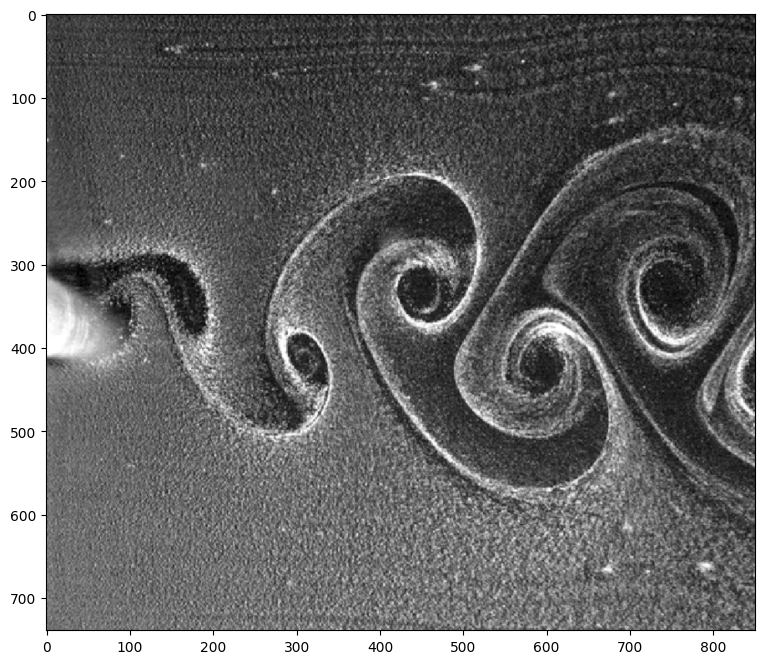

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [16,8]
A =imread(os.path.join('./Karman.png'))
X = np.mean(A,-1); # Convert RGB to grayscale
print(X.shape)
img = plt.imshow(X, cmap='gray')
plt.show()

### 1. Compute the economy SVD

In [ ]:
U,s,VT = np.linalg.svd(X, full_matrices=False) # economy svd

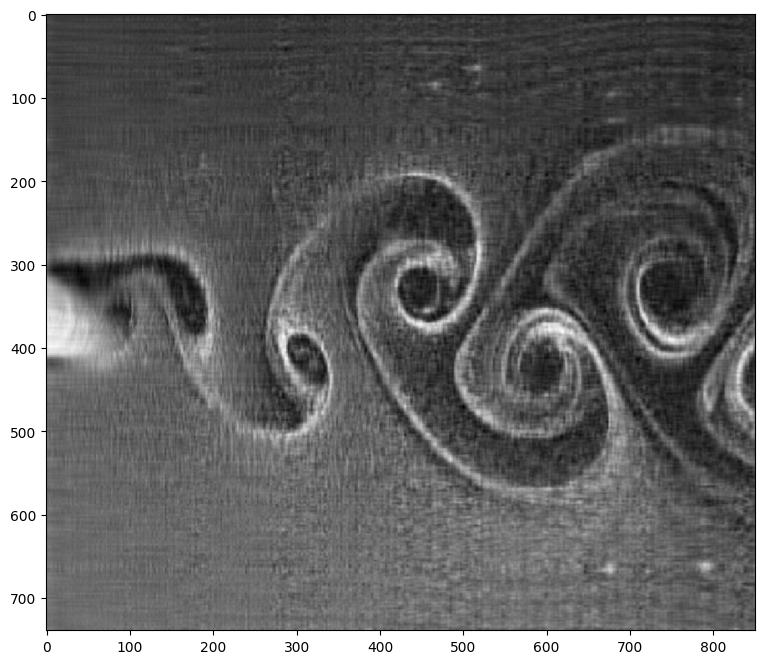

In [10]:
def reduced_svd(U,s,VT, r):
    return U[:, :r] @ np.diag(s[:r]) @ VT[:r, :]   # The reduced SVD


img = plt.imshow(reduced_svd(U,s,VT, 30), cmap = 'gray')

### 2. Let **X** be the matrix representing the true image and $\tilde{X}$ the approximation of rank \(r\) obtained using the SVD. Compute and plot the relative reconstruction error of the truncated SVD in the Frobenius norm as a function of the rank \(r\). The expression of the relative reconstruction error is given by:

$$\frac{\|\mathbf{X} - \tilde{\mathbf{X}}\|_F}{\|\mathbf{X}\|_F}$$


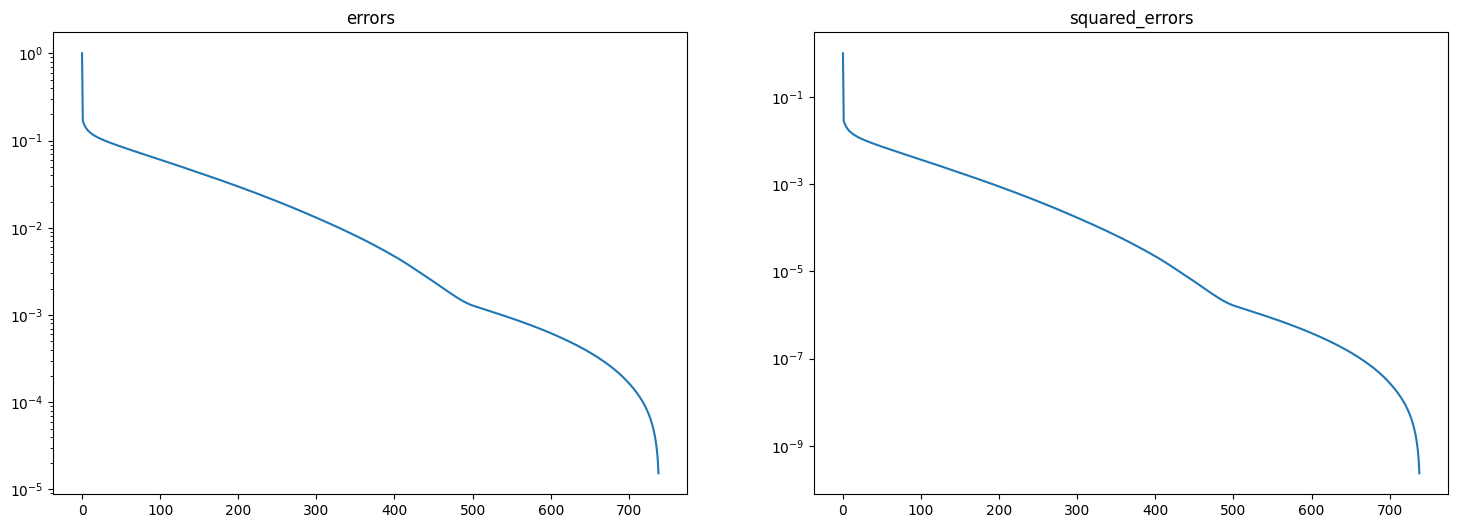

In [19]:
N = np.min([X.shape[0], X.shape[1]])
errors = []
squared_errors = []

def reconstruction_error(X, X_approx):
    return np.linalg.norm(X - X_approx, 'fro') / np.linalg.norm(X, 'fro')

fig,axs = plt.subplots(1,2,figsize = (18,6))

for r in range(N):
    error = reconstruction_error(X, reduced_svd(U,s,VT,r))
    errors.append(error)
    squared_errors.append(error**2)
# the frobenius norm is the sqrt(trace(X*XT)) of the covariance matrix
# therefore the relative error calculated is the fraction of the missing variance

axs[0].semilogy(errors)
axs[0].set_title('errors')

axs[1].semilogy(squared_errors)
axs[1].set_title('squared_errors')
    
plt.show()

The frobenius norm is the sqrt(trace(X*XT)) of the covariance matrix therefore the relative error calculated is the fraction of the missing variance



  0%|          | 0/80 [00:00<?, ?it/s]

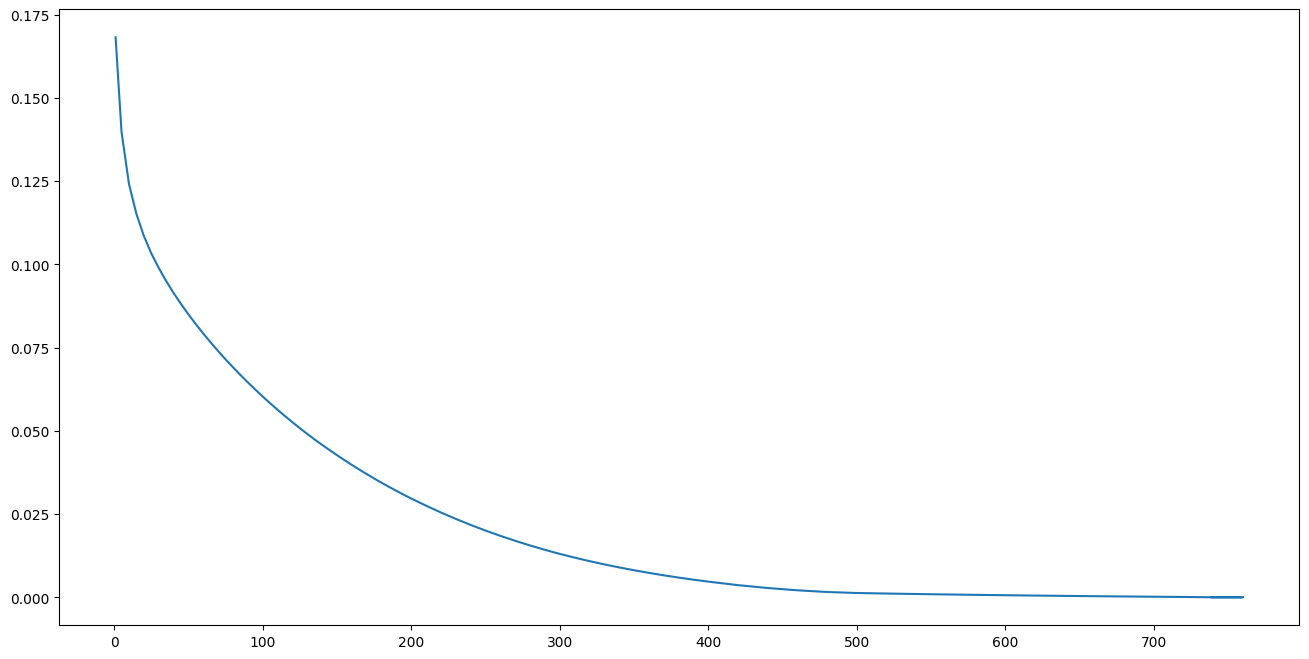

In [20]:
rank = [1]
rank = np.append(rank, np.arange(5, 200,5))
rank = np.append(rank, np.arange(200, 400,10))
rank = np.append(rank, np.arange(400, 768, 20))
rank = np.append(rank, [739])


from tqdm.notebook import tqdm
def reconstruct(U, s, VT, rank):
    return np.matmul(U[:,:rank], np.matmul(np.diag(s[:rank]),VT[:rank,:]))

def reconstruction_error(X, X_approx):
    return np.linalg.norm(X-X_approx, ord='fro')/np.linalg.norm(X, ord='fro')

errors = []
for r in tqdm(rank):
    errors.append(reconstruction_error(X, reconstruct(U, s, VT, r)))
    
plt.plot(rank, errors)

### 3. Square this error (and plot it) to compute the fraction of the missing variance as a function of r.


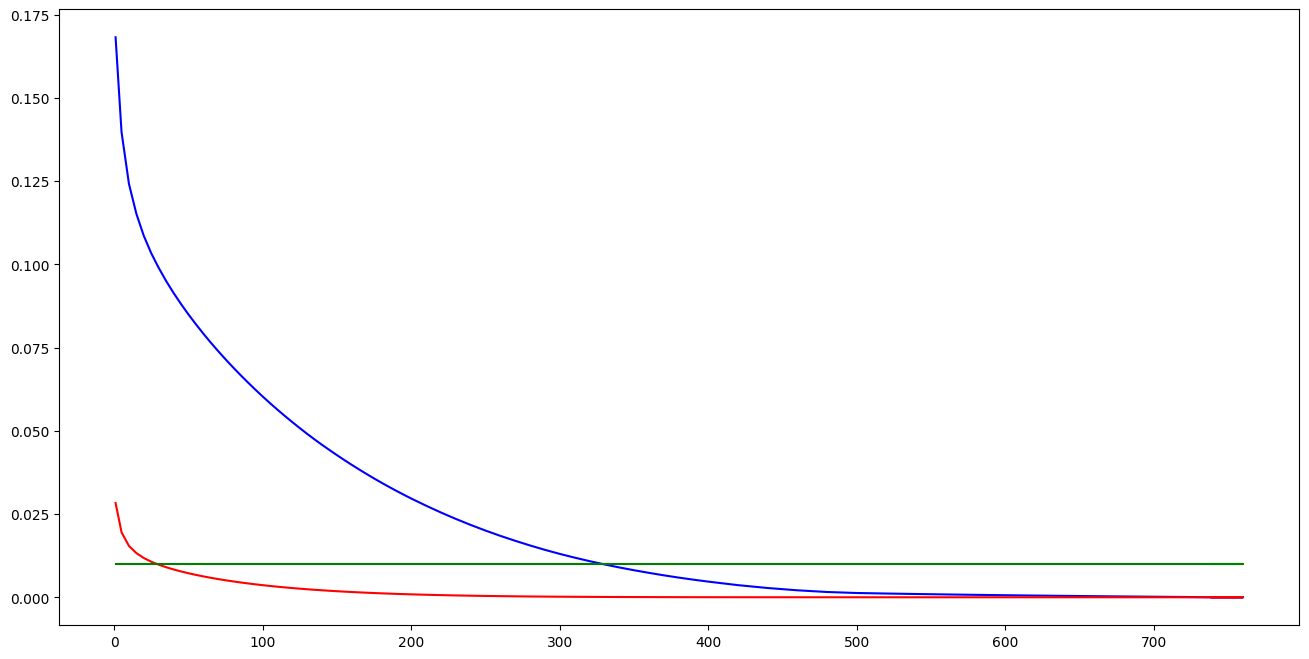

In [21]:
variances = []
for error in errors:
    variances.append(error**2)

plt.plot(rank, errors, color='blue')
plt.plot(rank, variances, color='red')
plt.plot(rank, np.ones(len(rank))*0.01, color='green')

###  4. Find the rank $\tilde{r}$ for which the reconstruction captures 99% of the total variance.


In [34]:
low_ranks = np.arange(10, 400, 1)
searched_rank = -1
for r in low_ranks:
    unexplained_variance = reconstruction_error(X, reconstruct(U,s,VT, r))**2
    if unexplained_variance <= 0.01:
        print(unexplained_variance)
        searched_rank = r
        break
print('searched rank is: ', searched_rank)
print("explained variance is: ", 1 - unexplained_variance)

0.009958797901934213
searched rank is:  29
explained variance is:  0.9900412020980658


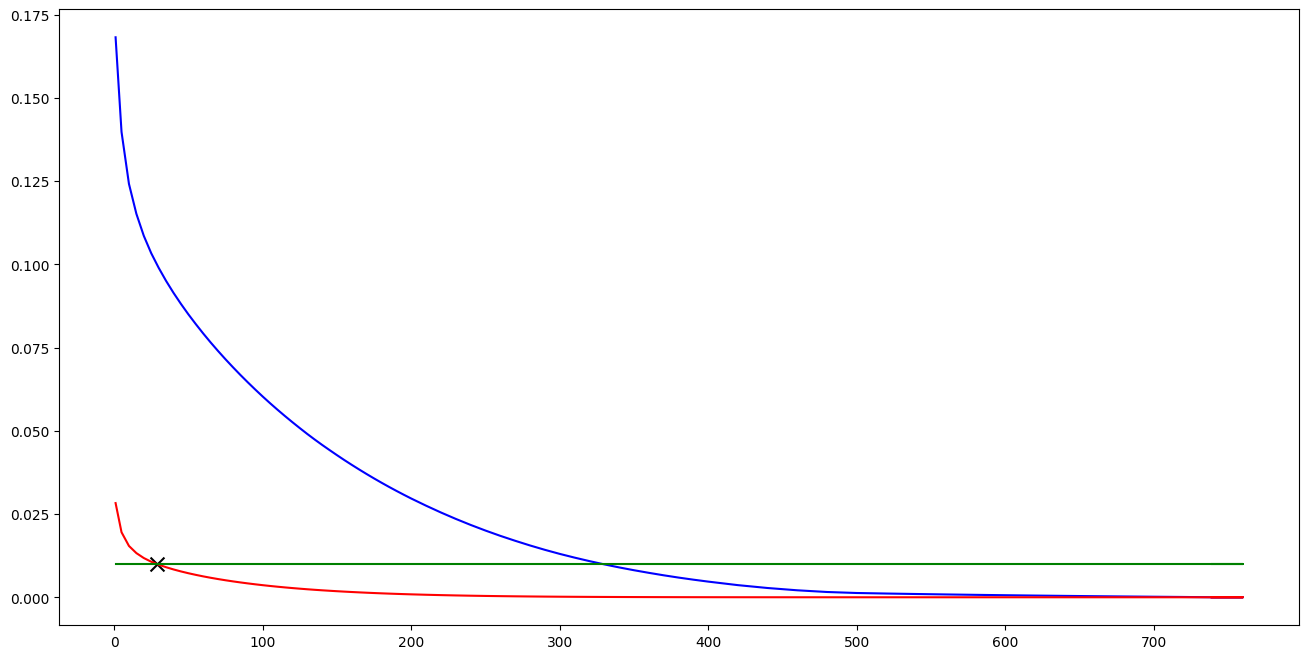

In [35]:
plt.plot(rank, errors, color='blue')
plt.plot(rank, variances, color='red')
plt.plot(rank, np.ones(len(rank)) * 0.01, color='green')
plt.scatter(searched_rank, unexplained_variance, color='black', marker='x', s=100)

# Exercise 2

Generate 100 artificial data points (xi , yi ) where xi is randomly generated in the interval [0, 1] and yi = cos(4πxi ) + ϵ; ϵ is a random noise in the interval [−0.2, 0.2].

Implement the SGD method to solve the regression problem for the data you have generated.

Use an initial constant learning rate η = 0.001 an train a polynomial of the form hc = c0 + c1 x + c2 x2 + . . . + cn xn using your data (n is the maximum degree of the polynomial).

Assume that all the initial parameters ci are randomly generated in [−0.4, 0.4]. Try different values of n.

Try also different values for α to speed up the learning process. Plot the various results and comment them.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax

In [43]:
f = lambda x: np.cos(4*np.pi*x) 
a, b = 0, 1

In [53]:
def get_training_data(N, x_range, noise_range):
  np.random.seed(0) # for reproducibility
  x = np.linspace(x_range[0], x_range[1], N)
  noise = np.random.uniform(noise_range[0], noise_range[1], N)  # Rumore in [-0.2, 0.2]
  y = f(x) + noise
  return x, y

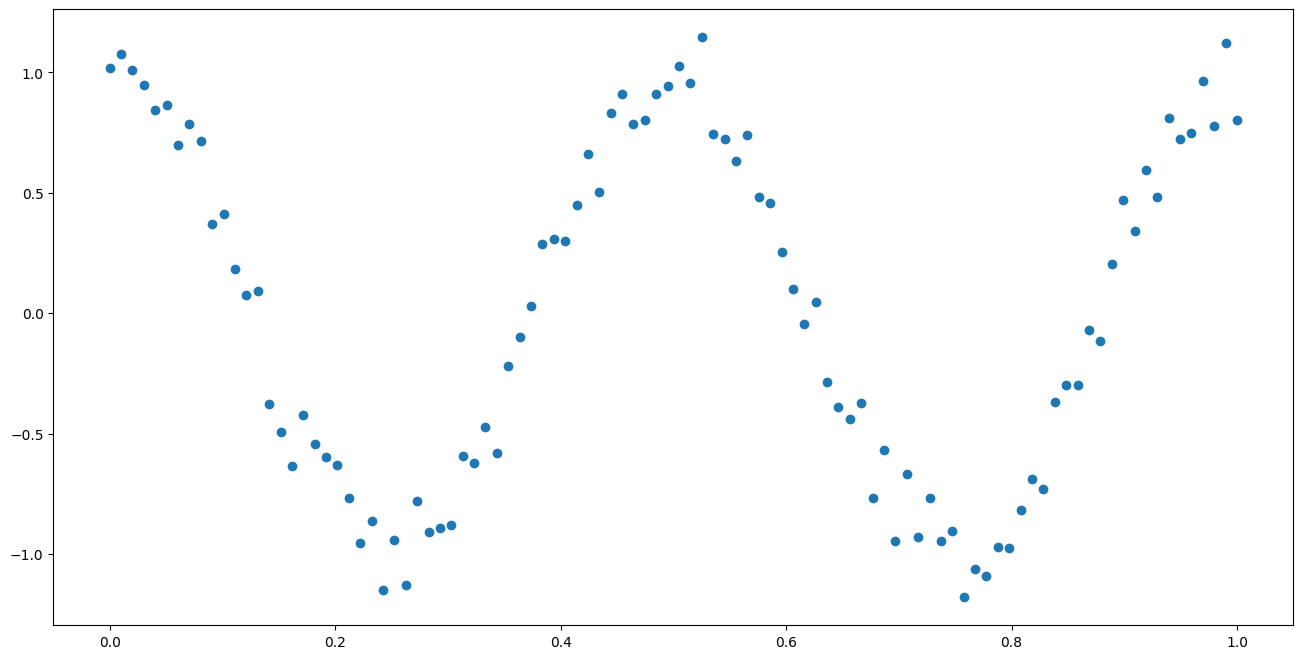

In [54]:
N=100
noise_range = [-0.2, 0.2]
x,y = get_training_data(N, [a,b], noise_range)

plt.scatter(x,y)

In [56]:
noise = np.random.uniform(noise_range[0], noise_range[1], N)  # Noise in [-0.2, 0.2]

In [55]:
x_range = [a,b]
x = np.linspace(x_range[0], x_range[1], N)

In [57]:
from tqdm.notebook import tqdm


1. Polynomial interpolation and regression.
2. Optimization techniques like **Gradient Descent (GD)**.
3. Matrix decompositions such as **SVD** (Singular Value Decomposition).

---

### Polynomial Regression

The goal of polynomial regression is to approximate a function \( f(x) \) by fitting a polynomial:

$$
P(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n
$$

where:

- $a_0, a_1, \ldots, a_n$ are the polynomial coefficients (parameters).
- \( n \) is the degree of the polynomial.

---

### Loss Function

The mean squared error (MSE) is used to evaluate how well the polynomial approximates the data:

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( P(x_i) - y_i \right)^2
$$

where:

- \( N \): Number of data points.
- \( P(x_i) \): Predicted value for \( x_i \).
- \( y_i \): True value for \( x_i \).

The objective is to minimize the loss function with respect to the coefficients \( a_0, a_1, \ldots, a_n \).

---

### Gradient Descent (GD)

To minimize the loss function, we use **Gradient Descent**. The coefficients are updated iteratively as:

$$
a_j \leftarrow a_j - \eta \frac{\partial \text{MSE}}{\partial a_j}
$$

where:

- \( \eta \): Learning rate (step size).
- \( \frac{\partial \text{MSE}}{\partial a_j} \): Gradient of the loss with respect to the coefficient \( a_j \).

---

### JAX in Machine Learning

[JAX](https://jax.readthedocs.io/) is a Python library that enables efficient numerical computation and automatic differentiation. It is particularly useful in Machine Learning tasks.

Key features of JAX used in this project include:

1. **Automatic Differentiation**:
   JAX computes gradients efficiently with its `grad` function.
2. **JIT Compilation**:
   The `jax.jit` decorator accelerates code execution by compiling it into optimized machine code.

Example of using JAX for gradient computation:

```python
import jax
import jax.numpy as jnp

# Define the polynomial loss
def loss(x, y, params):
    error = evaluate_polynomial(x, params) - y
    return jnp.mean(error ** 2)

# Compute gradients with respect to parameters
grad_fn = jax.grad(loss, argnums=2)  # Gradient w.r.t params


In [58]:
def evaluate_polynomial(x,params):
    # params is a list of coefficients [a0, a1, ..., an]
    # they are related to the polynomial P(x) = a0 + a1 x + a2 x^2 + ... + an x^n
    out = jnp.zeros(len(x))
    for i in range(len(params)):
        out += jnp.power(x,i)*params[i]
    return out

In [59]:
def loss(x, y, params):
  error =  evaluate_polynomial(x, params) - y
  return jnp.mean(error * error)

In [71]:
(np.random.rand(1)[0] - 0.5)* 0.8

-0.22648241248122086

In [74]:
def initialize_params(n):
    params = []
    for i in range(n+1):
        params.append((np.random.rand(1)[0] - 0.5)*0.8)
    return params

In [73]:
def SGD(n_samples, num_epochs, batch_size, learning_rate, x_train, y_train, params, grad_jit, loss_jit):
    history_train = list()
    history_train.append(loss_jit(x_train, y_train, params))
    
    for epoch in range(num_epochs):
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs], y_train[idxs], params)
        
        for i in range(len(params)):
            params[i] -= learning_rate * grads[i]
    
        history_train.append(loss_jit(x_train, y_train, params))
    return params, history_train

In [76]:
eta = 1e-3
n_array = np.array([0,2,5,20,100])
num_epochs = 5000
n_samples = len(x)
batch_size = 10

fig, axs = plt.subplots(nrows=len(n_array), ncols=2, figsize=(20,30))

grad = jax.jit(jax.grad(loss, argnums=2))
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

i=0 #counter
for n in tqdm(n_array):
    params, history_train = SGD(n_samples, num_epochs, batch_size, eta, x, y, initialize_params(n), grad_jit, loss_jit)

    axs[i][0].loglog(history_train, label = 'train')
    axs[i][0].set_title(f'n = {n} loss')

    baseline = np.arange(0,1, 2e-2)
    axs[i][1].scatter(x,y, color='red')
    axs[i][1].plot(baseline, evaluate_polynomial(baseline, params))
    axs[i][1].set_title(f'n = {n} reconstruction')
    i += 1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

best learning rate is: 0.1 with loss: 0.3624139428138733


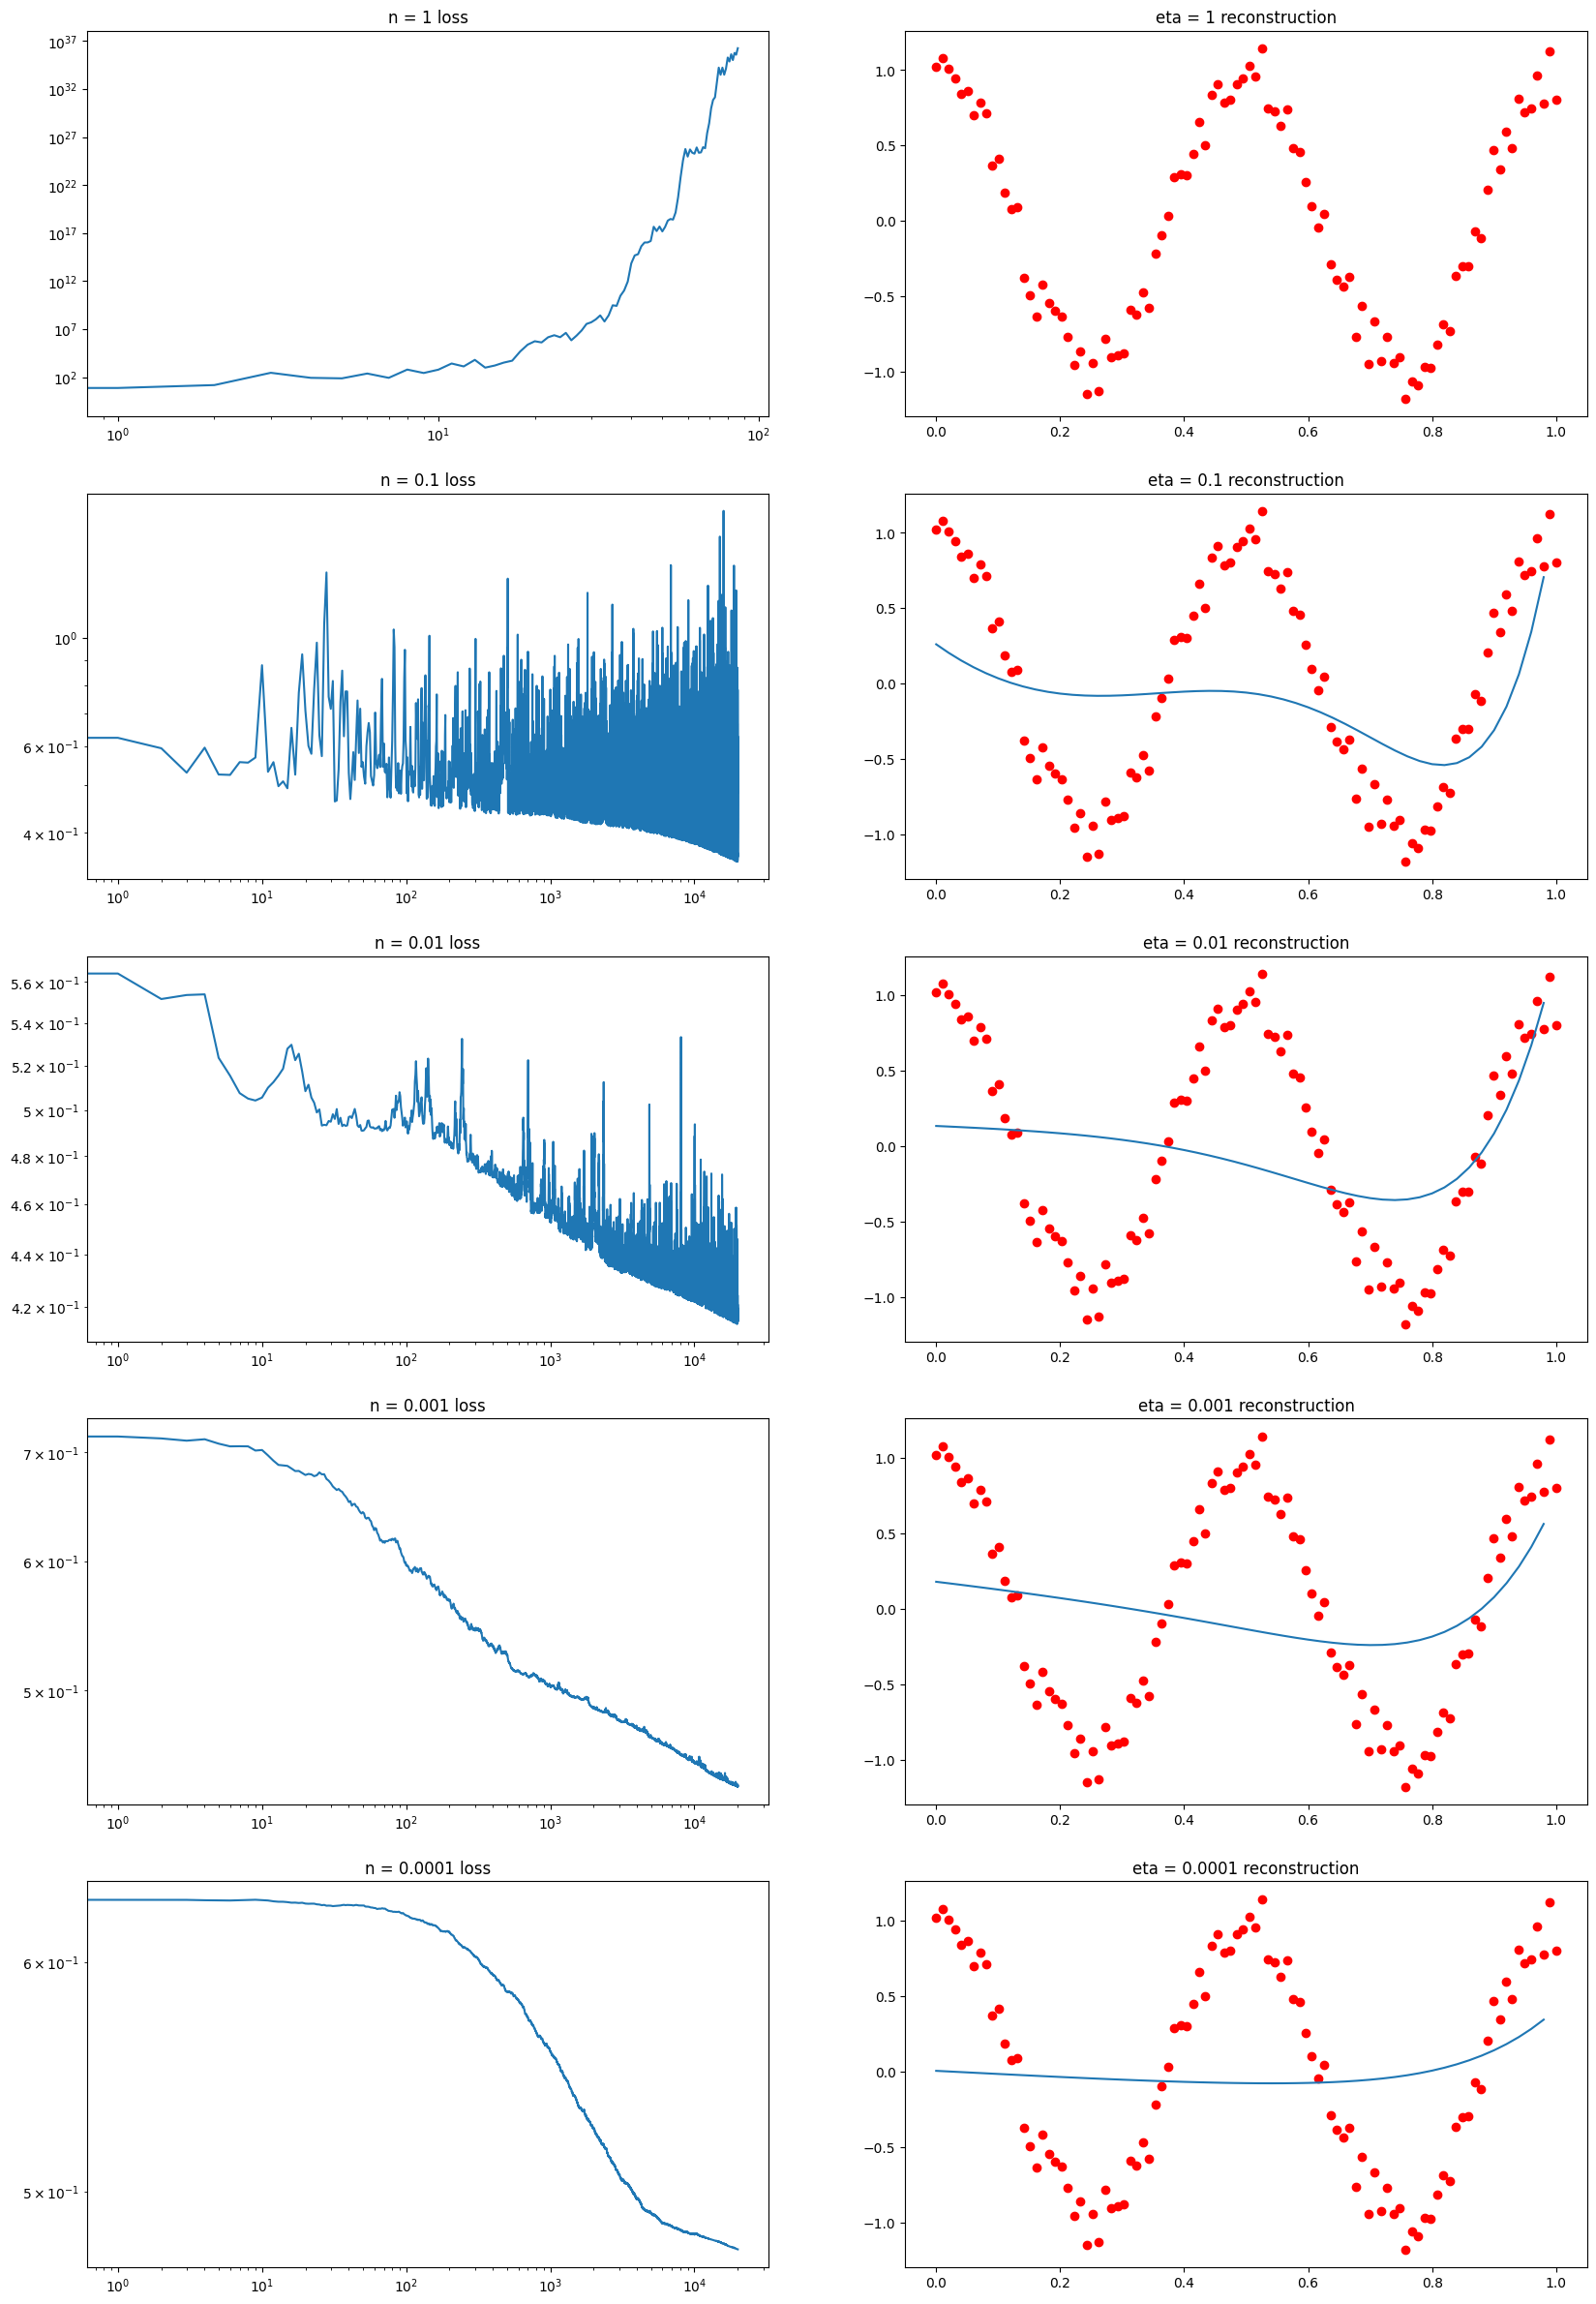

In [77]:
eta_array = [1, 1e-1, 1e-2, 1e-3, 1e-4] # learning rates to test
n = 8 # fixed degree of the polynomial
num_epochs = 20000     # Number of epochs for training
batch_size = 1     # Mini-batch size for SGD
n_samples = len(x) 

fig, axs = plt.subplots(nrows=len(n_array), ncols=2, figsize=(20,30))

grad = jax.jit(jax.grad(loss, argnums=2))
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

i=0
minimum_loss = -1 # placeholder value
best_eta = -1 # placeholder value

for eta in tqdm(eta_array):
    params, history_train = SGD(n_samples, num_epochs, batch_size, eta, x, y, initialize_params(n), grad_jit, loss_jit)

    if minimum_loss == -1 and not(np.isnan(history_train[-1])):
        minimum_loss = history_train[-1] # last evaluated loss
        best_eta = eta
    elif minimum_loss > history_train[-1]:
        minimum_loss = history_train[-1]
        best_eta = eta
    axs[i][0].loglog(history_train, label = 'train')
    axs[i][0].set_title(f'n = {eta} loss')

    baseline = np.arange(0,1, 2e-2)
    axs[i][1].scatter(x,y, color='red')
    axs[i][1].plot(baseline, evaluate_polynomial(baseline, params))
    axs[i][1].set_title(f'eta = {eta} reconstruction')
    i += 1


print(f'best learning rate is: {best_eta} with loss: {minimum_loss}')


Notes
- The grade n of the polynomial does not particularly impact the obtained graph for a relatively small number of iterations. However from the theory we know that if it is too big it may cause overfitting. In particular a order 4 polynomial should already provide a good representation for the data due to it's possibility to have 3 changes of convexity.
- The learning rate proved to be a more impactful parameter. In particular choosing it too small the convergence became too slow, changing it too big make the convergence faster but induce more variance.
- The best learning rate for a relatively low number of iteration is between 0.1 and 0.01
- The difficulty of the process of finding the best polynomial is due to the fact that the proposed function is perodic which makes the SGD easily proceed in the wrong direction